<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/mmlu_eval_openai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building an MMLU Eval

This notebook shows how to:
- Build and run an eval
- Load the results and into a Pandas Dataframe

We use the `evals.elsuite.basic.match:Match` Eval class here to check whether new completions match the correct answer. Under the hood, it will generate a completion with the choice of model for each prompt, check if the completion matches the true answer, then logs a result.

In [ ]:
!git clone https://github.com/openai/evals.git

In [ ]:
# Install, and download MMLU if you haven't already
%cd /content/evals/
%pip install -e . -q

In [ ]:
!curl -O https://people.eecs.berkeley.edu/~hendrycks/data.tar
!tar -xf data.tar
data_path = "data"

In [4]:
import pandas as pd
import os

# Assuming this notebook is in examples/
registry_path = os.path.join(os.getcwd(), "/content/evals/registry")
print(registry_path)

/content/evals/registry


In [5]:
# Build the prompts using Chat format. We support converting Chat conversations to text for non-Chat models

choices = ["A", "B", "C", "D"]
sys_msg = "The following are multiple choice questions (with answers) about {}."
def create_chat_prompt(sys_msg, question, answers, subject):
    user_prompt = f"{question}\n" + "\n".join([f"{choice}. {answer}" for choice, answer in zip(choices, answers)]) + "\nAnswer:"
    return [
        {"role": "system", "content": sys_msg.format(subject)},
        {"role": "user", "content": user_prompt}
    ]

def create_chat_example(question, answers, correct_answer):
    """
    Form few-shot prompts in the recommended format: https://github.com/openai/openai-python/blob/main/chatml.md#few-shot-prompting
    """
    user_prompt = f"{question}\n" + "\n".join([f"{choice}. {answer}" for choice, answer in zip(choices, answers)]) + "\nAnswer:"
    return [
        {"role": "system", "content": user_prompt, "name": "example_user"},
        {"role": "system", "content": correct_answer, "name": "example_assistant"},
    ]

In [6]:
data_path='/content/evals/data'

In [7]:
import yaml
subjects = sorted([f.split("_test.csv")[0] for f in os.listdir(os.path.join(data_path, "test")) if "_test.csv" in f])

registry_yaml = {}

for subject in subjects:
    subject_path = os.path.join(registry_path, "data", "mmlu", subject)
    os.makedirs(subject_path, exist_ok=True)

    # Create few-shot prompts
    dev_df = pd.read_csv(os.path.join(data_path, "dev", subject + "_dev.csv"), names=("Question", "A", "B", "C", "D", "Answer"))
    dev_df["sample"] = dev_df.apply(lambda x: create_chat_example(x["Question"], x[["A", "B", "C", "D"]], x["Answer"]), axis=1)
    few_shot_path = os.path.join(subject_path, "few_shot.jsonl")
    dev_df[["sample"]].to_json(few_shot_path, lines=True, orient="records")

    # Create test prompts and ideal completions
    test_df = pd.read_csv(os.path.join(data_path, "test", subject + "_test.csv"), names=("Question", "A", "B", "C", "D", "Answer"))
    test_df["input"] = test_df.apply(lambda x: create_chat_prompt(sys_msg, x["Question"], x[["A", "B", "C", "D"]], subject), axis=1)
    test_df["ideal"] = test_df.Answer
    samples_path = os.path.join(subject_path, "samples.jsonl")
    test_df[["input", "ideal"]].to_json(samples_path, lines=True, orient="records")

    eval_id = f"match_mmlu_{subject}"

    registry_yaml[eval_id] = {
        "id": f"{eval_id}.test.v1",
        "metrics": ["accuracy"]
    }
    registry_yaml[f"{eval_id}.test.v1"] = {
        "class": "evals.elsuite.basic.match:Match",
        "args": {
            "samples_jsonl": samples_path,
            "few_shot_jsonl": few_shot_path,
            "num_few_shot": 4,
        }
    }
registry_path = '/content'
with open(os.path.join(registry_path, "evals", "mmlu.yaml"), "w") as f:
    yaml.dump(registry_yaml, f)

In [8]:
!pip install colab-env --upgrade -q
!pip install openai -q
import colab_env
import os
import openai
from openai import OpenAI
client = OpenAI(api_key = os.getenv("OPENAI_API_KEY"))

  Preparing metadata (setup.py) ... done
Mounted at /content/gdrive


In [ ]:
from openai import OpenAI
client = OpenAI()

modellist=client.models.list()
modellist.data

In [12]:
#'mmlu-abstract-algebra', 'mmlu-abstract-algebra.val.ab-v1', 'mmlu-anatomy',
#'mmlu-anatomy.val.ab-v1', 'mmlu-astronomy', 'mmlu-astronomy.val.ab-v1',
#'mmlu-business-ethics', 'mmlu-business-ethics.val.ab-v1', 'mmlu-clinical-knowledge',
#'mmlu-clinical-knowledge.val.ab-v1', 'mmlu-college-biology', 'mmlu-college-biology.val.ab-v1',
#'mmlu-college-chemistry', 'mmlu-college-chemistry.val.ab-v1', 'mmlu-college-computer-science',
#'mmlu-college-computer-science.val.ab-v1', 'mmlu-college-mathematics',
#'mmlu-college-mathematics.val.ab-v1', 'mmlu-college-medicine',
#'mmlu-college-medicine.val.ab-v1', 'mmlu-college-physics', 'mmlu-college-physics.val.ab-v1',
#'mmlu-computer-security', 'mmlu-computer-security.val.ab-v1', 'mmlu-conceptual-physics',
#'mmlu-conceptual-physics.val.ab-v1', 'mmlu-econometrics', 'mmlu-econometrics.val.ab-v1',
#'mmlu-electrical-engineering', 'mmlu-electrical-engineering.val.ab-v1',
#'mmlu-elementary-mathematics', 'mmlu-elementary-mathematics.val.ab-v1',
#'mmlu-formal-logic', 'mmlu-formal-logic.val.ab-v1', 'mmlu-global-facts',
#'mmlu-global-facts.val.ab-v1', 'mmlu-high-school-biology', 'mmlu-high-school-biology.val.ab-v1',
#'mmlu-high-school-chemistry'

In [13]:
# This will generate a JSONL which will record samples and logs and store it in /tmp/evallogs
#!oaieval gpt-3.5-turbo match_mmlu_anatomy

%rm -rf /tmp/evallogs/*

#!oaieval gpt-3.5-turbo arc
#!oaieval gpt-3.5-turbo marxist_philosophy_exam

# abstract-causal-reasoning-text
# arc
# belarusian-antonyms

#!oaieval gpt-3.5-turbo belarusian-antonyms
!oaieval gpt-3.5-turbo GPT-model-text-detection
# marxist_philosophy_exam


[2024-05-28 20:26:26,080] [registry.py:271] Loading registry from /content/evals/evals/registry/evals
[2024-05-28 20:26:27,746] [registry.py:271] Loading registry from /root/.evals/evals
[2024-05-28 20:26:27,748] [oaieval.py:215] Run started: 24052820262764SDKAM5
[2024-05-28 20:26:27,994] [data.py:94] Fetching /content/evals/evals/registry/data/GPT-model-text-detection/samples.jsonl
[2024-05-28 20:26:27,998] [eval.py:36] Evaluating 152 samples
[2024-05-28 20:26:28,013] [eval.py:144] Running in threaded mode with 10 threads!
 32% 49/152 [00:15<00:21,  4.73it/s][2024-05-28 20:26:43,466] [record.py:360] Logged 100 rows of events to /tmp/evallogs/24052820262764SDKAM5_gpt-3.5-turbo_GPT-model-text-detection.jsonl: insert_time=84.069ms
 64% 97/152 [00:28<00:18,  2.96it/s][2024-05-28 20:26:56,607] [record.py:360] Logged 100 rows of events to /tmp/evallogs/24052820262764SDKAM5_gpt-3.5-turbo_GPT-model-text-detection.jsonl: insert_time=230.530ms
 98% 149/152 [00:41<00:00,  3.45it/s][2024-05-28 20

In [14]:
# import OS module
import os
# Get the list of all files and directories
path0 = "/tmp/evallogs/"
dir_list = os.listdir(path0)
events=path0
#print("Files and directories in '", events, "' :")
# prints all files
#print(dir_list)
events='%s%s'%(path0,dir_list[0])
print(events)

/tmp/evallogs/24052820262764SDKAM5_gpt-3.5-turbo_GPT-model-text-detection.jsonl


<Axes: title={'center': 'Correctness of generated answers'}, xlabel='Correctness', ylabel='Count'>

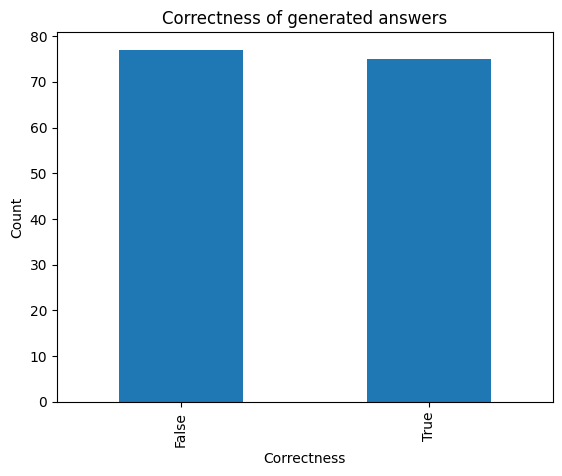

In [17]:
# How to process the log events generated by oaieval
#events = "/tmp/evallogs/{log_name}"

with open(events, "r") as f:
    events_df = pd.read_json(f, lines=True)

matches_df = events_df[events_df.type == "match"].reset_index(drop=True)
matches_df = matches_df.join(pd.json_normalize(matches_df.data))
matches_df.correct.value_counts().plot.bar(title="Correctness of generated answers", xlabel="Correctness", ylabel="Count")

In [16]:
# Inspect samples
for i, r in pd.json_normalize(events_df[events_df.type == "sampling"].data).iterrows():
    print(f"Prompt: {r.prompt}")
    print(f"Sampled: {r.sampled}")
    print("-" * 25)

Prompt: [{'role': 'system', 'content': 'Examine the provided text and classify weather it is generated by GPT model text-davinci-001 or not. Provide your reasoning step by step, and at the end, write your final answer, yes or no, enclosed in square brackets like [Yes] or [No].'}, {'role': 'user', 'content': "The Cat in the Hat is a classic children's book written by Dr. Seuss. It tells the story of two kids, Sally and her brother, who are home alone on a rainy day and find a tall, mysterious cat in a hat. The Cat introduces them to a world of outrageous fun and adventure, with Thing 1 and Thing 2 causing havoc in the house. The Cat eventually cleans up the mess he made, but not before teaching Sally and her brother about the importance of being creative and imaginative."}]
Sampled: ['1. The text describes the plot of a well-known children\'s book, "The Cat in the Hat" by Dr. Seuss.\n2. It summarizes the main characters and events of the story accurately.\n3. The text is coherent and pr